# Prep

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import pickle

In [2]:
TRAIN = 0.8
HIDDEN_LAYERS = 3
NEURONS = 1280
EPOCHS = 50
BATCH_SIZE = 320

## Data

In [3]:
file = open("data\\data.txt", "r")
input_data = file.readlines()
file.close()

In [4]:
data = [] # [score, turn, board]
for id in input_data:
    data.append(id.split())

In [5]:
test = int(len(data) * TRAIN)
train_data = data[:test]
test_data = data[test:]

def split_data(data):
    X = []
    y = []
    for d in data:
        temp = []
        for i in range(1, len(d)):
            temp.append(d[i])
        X.append(temp)
        y.append(d[0])
    return X, y

X_train, y_train = split_data(train_data)
X_test, y_test = split_data(test_data)

print(f"X_train shape: {len(X_train)}, X_train[0] shape: {len(X_train[0])}, y_train shape: {len(y_train)}")
print(f"X_test shape: {len(X_test)}, y_test shape: {len(y_test)}")

X_train shape: 10314, X_train[0] shape: 15, y_train shape: 10314
X_test shape: 2579, y_test shape: 2579


In [6]:
X_train = torch.tensor(np.array(X_train, dtype=np.float64))
y_train = torch.tensor(np.array(y_train, dtype=np.float64))
X_test = torch.tensor(np.array(X_test, dtype=np.float64))
y_test = torch.tensor(np.array(y_test, dtype=np.float64))

print(X_train)
print(y_train)

tensor([[0.0000e+00, 1.6000e+01, 0.0000e+00,  ..., 1.4311e+14, 1.3849e+08,
         1.4060e+19],
        [1.0000e+00, 1.6000e+01, 0.0000e+00,  ..., 1.4311e+14, 1.3849e+08,
         1.4060e+19],
        [0.0000e+00, 1.6000e+01, 0.0000e+00,  ..., 1.4311e+14, 1.3849e+08,
         1.4060e+19],
        ...,
        [0.0000e+00, 1.6000e+01, 0.0000e+00,  ..., 3.6134e+16, 2.9454e+06,
         1.5529e+19],
        [1.0000e+00, 1.6000e+01, 0.0000e+00,  ..., 3.6134e+16, 2.9454e+06,
         1.5529e+19],
        [0.0000e+00, 1.6000e+01, 0.0000e+00,  ..., 3.6134e+16, 2.9454e+06,
         1.5529e+19]], dtype=torch.float64)
tensor([0.4000, 0.3957, 0.3913,  ..., 0.3765, 0.3706, 0.3647],
       dtype=torch.float64)


In [7]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model 

In [8]:
class Model(torch.nn.Module):
    def __init__(self, neurons, hidden_layers):
        super(Model, self).__init__()
        self.hidden_layers = hidden_layers
        self.fc1 = torch.nn.Linear(15, neurons)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(neurons, 1)

        self.layers = []
        for _ in range(hidden_layers):
            self.layers.append(torch.nn.Linear(neurons, neurons, dtype=torch.float64))
            self.layers.append(torch.nn.ReLU())
        
        self.double()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        for i in range(self.hidden_layers):
            x = self.layers[i*2](x)
            x = self.layers[i*2+1](x)
        x = self.fc2(x)
        return x

In [9]:
model = Model(NEURONS, HIDDEN_LAYERS)
print(model)

Model(
  (fc1): Linear(in_features=15, out_features=1280, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1280, out_features=1, bias=True)
)


In [10]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train

In [11]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [12]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    model.train()
    for X_batch, Y_batch in tqdm(dataloader):
        # print(X_batch)
        # print(Y_batch)
        optimizer.zero_grad()
        Y_pred = model(X_batch)
        loss = loss_fn(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += torch.sum(torch.abs(torch.sub(Y_batch, Y_pred)))
        # print(train_accuracy)
        batch_cnt += 1
    print(f"Epoch {epoch} loss: {loss.item()}")

    model.eval()
    with torch.no_grad():
        Y_pred = model(X_test)
        val_loss = loss_fn(Y_pred, y_test)
        val_accuracy += torch.sum(torch.abs(torch.sub(y_test, Y_pred)))

        history['accuracy'].append(train_accuracy / batch_cnt)
        history['loss'].append(train_loss / batch_cnt)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(val_loss)
    # print(f"Validation loss: {val_loss.item()}")
    # print(f"Validation accuracy: {val_accuracy}")

print("Finished Training")

  0%|          | 0/33 [00:00<?, ?it/s]C:\Users\Simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([320])) that is different to the input size (torch.Size([320, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 32/33 [00:02<00:00, 12.33it/s]C:\Users\Simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 33/33 [0

Epoch 0 loss: 7.874497079396999e+31


100%|██████████| 33/33 [00:02<00:00, 13.30it/s]


Epoch 1 loss: 2.745093960411366e+30


100%|██████████| 33/33 [00:02<00:00, 13.29it/s]


Epoch 2 loss: 9.357944612985091e+28


100%|██████████| 33/33 [00:02<00:00, 13.14it/s]


Epoch 3 loss: 4.871755852561874e+28


100%|██████████| 33/33 [00:02<00:00, 13.53it/s]


Epoch 4 loss: 3.5163652203082683e+28


100%|██████████| 33/33 [00:02<00:00, 13.60it/s]


Epoch 5 loss: 1.5015079606575308e+28


100%|██████████| 33/33 [00:02<00:00, 13.42it/s]


Epoch 6 loss: 8.857473524555347e+27


100%|██████████| 33/33 [00:02<00:00, 13.46it/s]


Epoch 7 loss: 7.747939923967205e+27


100%|██████████| 33/33 [00:02<00:00, 13.13it/s]


Epoch 8 loss: 9.093858682477716e+27


100%|██████████| 33/33 [00:02<00:00, 12.47it/s]


Epoch 9 loss: 5.931912069210176e+27


100%|██████████| 33/33 [00:02<00:00, 13.25it/s]


Epoch 10 loss: 5.80540396158418e+27


100%|██████████| 33/33 [00:02<00:00, 13.40it/s]


Epoch 11 loss: 6.081282136849617e+27


100%|██████████| 33/33 [00:02<00:00, 13.46it/s]


Epoch 12 loss: 3.280958221714973e+27


100%|██████████| 33/33 [00:02<00:00, 13.49it/s]


Epoch 13 loss: 4.137525091044254e+27


100%|██████████| 33/33 [00:02<00:00, 12.74it/s]


Epoch 14 loss: 4.7826470727225997e+27


100%|██████████| 33/33 [00:02<00:00, 12.72it/s]


Epoch 15 loss: 1.6224345608382165e+27


100%|██████████| 33/33 [00:02<00:00, 12.86it/s]


Epoch 16 loss: 2.2858439310851743e+27


100%|██████████| 33/33 [00:02<00:00, 13.10it/s]


Epoch 17 loss: 2.5171565151473446e+27


100%|██████████| 33/33 [00:02<00:00, 12.85it/s]


Epoch 18 loss: 2.2945747441661135e+27


100%|██████████| 33/33 [00:02<00:00, 12.15it/s]


Epoch 19 loss: 1.6749130722986732e+27


100%|██████████| 33/33 [00:02<00:00, 12.51it/s]


Epoch 20 loss: 1.3408626372067248e+27


100%|██████████| 33/33 [00:02<00:00, 12.84it/s]


Epoch 21 loss: 1.2885769843171183e+27


100%|██████████| 33/33 [00:02<00:00, 12.92it/s]


Epoch 22 loss: 1.45891310708718e+27


100%|██████████| 33/33 [00:02<00:00, 13.05it/s]


Epoch 23 loss: 9.333403157800074e+26


100%|██████████| 33/33 [00:02<00:00, 13.10it/s]


Epoch 24 loss: 1.3797911912697696e+27


100%|██████████| 33/33 [00:02<00:00, 12.90it/s]


Epoch 25 loss: 1.096153620503737e+27


100%|██████████| 33/33 [00:02<00:00, 13.11it/s]


Epoch 26 loss: 4.2493722650384704e+26


100%|██████████| 33/33 [00:02<00:00, 12.73it/s]


Epoch 27 loss: 1.3301298584352946e+27


100%|██████████| 33/33 [00:02<00:00, 12.93it/s]


Epoch 28 loss: 1.1976231004647158e+27


100%|██████████| 33/33 [00:02<00:00, 12.68it/s]


Epoch 29 loss: 1.1773797804757235e+27


100%|██████████| 33/33 [00:02<00:00, 12.82it/s]


Epoch 30 loss: 3.9297692553955165e+26


100%|██████████| 33/33 [00:02<00:00, 13.11it/s]


Epoch 31 loss: 1.4084384972641458e+27


100%|██████████| 33/33 [00:02<00:00, 12.26it/s]


Epoch 32 loss: 6.7534700079887e+26


100%|██████████| 33/33 [00:02<00:00, 11.97it/s]


Epoch 33 loss: 8.321305504577425e+26


100%|██████████| 33/33 [00:02<00:00, 12.38it/s]


Epoch 34 loss: 8.353715763498549e+26


100%|██████████| 33/33 [00:02<00:00, 12.59it/s]


Epoch 35 loss: 5.9790481707666656e+26


100%|██████████| 33/33 [00:02<00:00, 12.57it/s]


Epoch 36 loss: 4.8390489751576194e+26


100%|██████████| 33/33 [00:02<00:00, 12.98it/s]


Epoch 37 loss: 2.7867607431880946e+26


100%|██████████| 33/33 [00:02<00:00, 12.63it/s]


Epoch 38 loss: 9.631633235992615e+26


100%|██████████| 33/33 [00:02<00:00, 12.76it/s]


Epoch 39 loss: 2.495993999774168e+26


100%|██████████| 33/33 [00:02<00:00, 12.56it/s]


Epoch 40 loss: 3.9448064140129026e+26


100%|██████████| 33/33 [00:02<00:00, 12.27it/s]


Epoch 41 loss: 1.2777939835924335e+27


100%|██████████| 33/33 [00:02<00:00, 12.89it/s]


Epoch 42 loss: 8.614997451723351e+26


100%|██████████| 33/33 [00:02<00:00, 12.26it/s]


Epoch 43 loss: 1.503819790445797e+27


100%|██████████| 33/33 [00:02<00:00, 11.95it/s]


Epoch 44 loss: 6.563307187234308e+26


100%|██████████| 33/33 [00:02<00:00, 12.59it/s]


Epoch 45 loss: 8.862990822233094e+26


100%|██████████| 33/33 [00:02<00:00, 12.38it/s]


Epoch 46 loss: 2.74651197044446e+27


100%|██████████| 33/33 [00:02<00:00, 12.24it/s]


Epoch 47 loss: 3.3854240722538506e+26


100%|██████████| 33/33 [00:02<00:00, 12.86it/s]


Epoch 48 loss: 1.00065593167396e+27


100%|██████████| 33/33 [00:02<00:00, 12.53it/s]


Epoch 49 loss: 5.835932677383335e+26
Finished Training


# Plot training

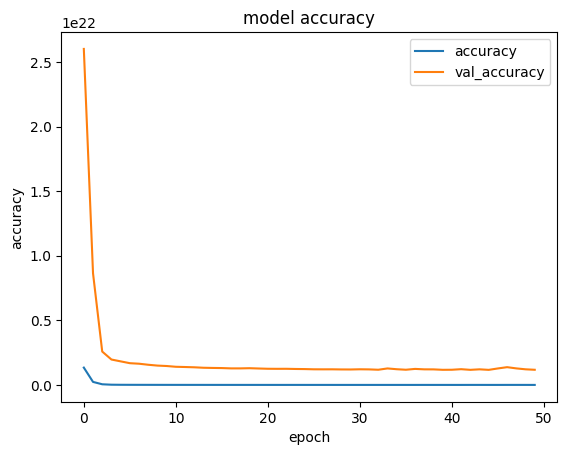

In [26]:
# accuracy
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()
plt.show()

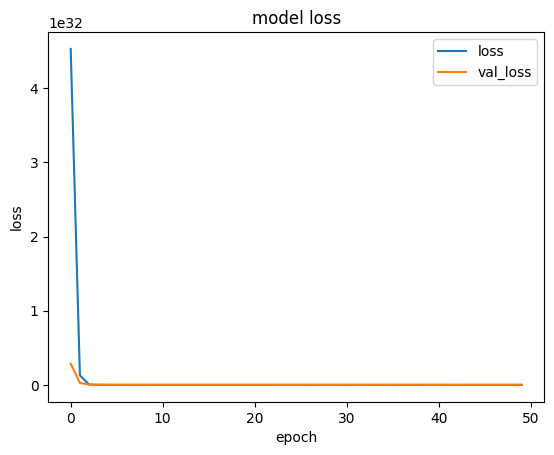

In [14]:
# loss
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend()
plt.show()

# Save Model 

In [15]:
import os.path
path = 'models'
num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])

path = f"models\\model{num_files}.pt"
torch.save(model.state_dict(), path)